# *Problem Statement* #
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.They have raised around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

We need to analyze the data and cluster the countires based on 
-some socio-economic and health factors that determine the overall development of the country.
-provide the list of top 10 countries to which the financial aid should be given

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Reading and Understanding the Data

### 1: Reading the data

In [3]:
## Reading the Country-data.csv file in a dataframe called countries
countries=pd.read_csv("Country-data.csv")

### 2: Inspecting the dataframe

Inspect the dataframe for dimensions, null-values, and summary of different numeric and categorical  columns.

In [4]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


In [5]:
# Check the number of rows and columns in the dataframe

countries.shape

(167, 10)

In [6]:
# Check the column-wise info of the dataframe
countries.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
# Check the summary for the numeric columns 
countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,17144.6886,7.7818,70.5557,2.9480,12964.1557
std,40.3289,27.4120,2.7468,24.2096,19278.0677,10.5707,8.8932,1.5138,18328.7048
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,208.0000,200.0000,17.9000,174.0000,125000.0000,104.0000,82.8000,7.4900,105000.0000


### 3: Handling Null vlaues and Missing Values

In [8]:
#check the number of null values
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

- Observation: No null/Missing values found in the dataset

### 4: Checking for duplicate data if any

In [9]:
# Create a dummy dataframe called dups_countries which is a copy of countries and check for duplicate  values 
dups_countries=countries
dups_countries.drop_duplicates(subset=None, inplace=True)

In [10]:
dups_countries.shape

(167, 10)

- Observation: No duplicates found as the original df countires and dups_countries has the same shape after duplicate check

In [11]:
# Columns exports,imports and health are expressed in percentages , converting them to absolute values.

countries['exports'] = (countries['exports']/100) * countries['gdpp']
countries['imports'] = (countries['imports']/100) * countries['gdpp']
countries['health'] = (countries['health']/100) * countries['gdpp']


In [12]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100,1.4400,76.8000,2.1300,12200


## EDA and Data Visualization

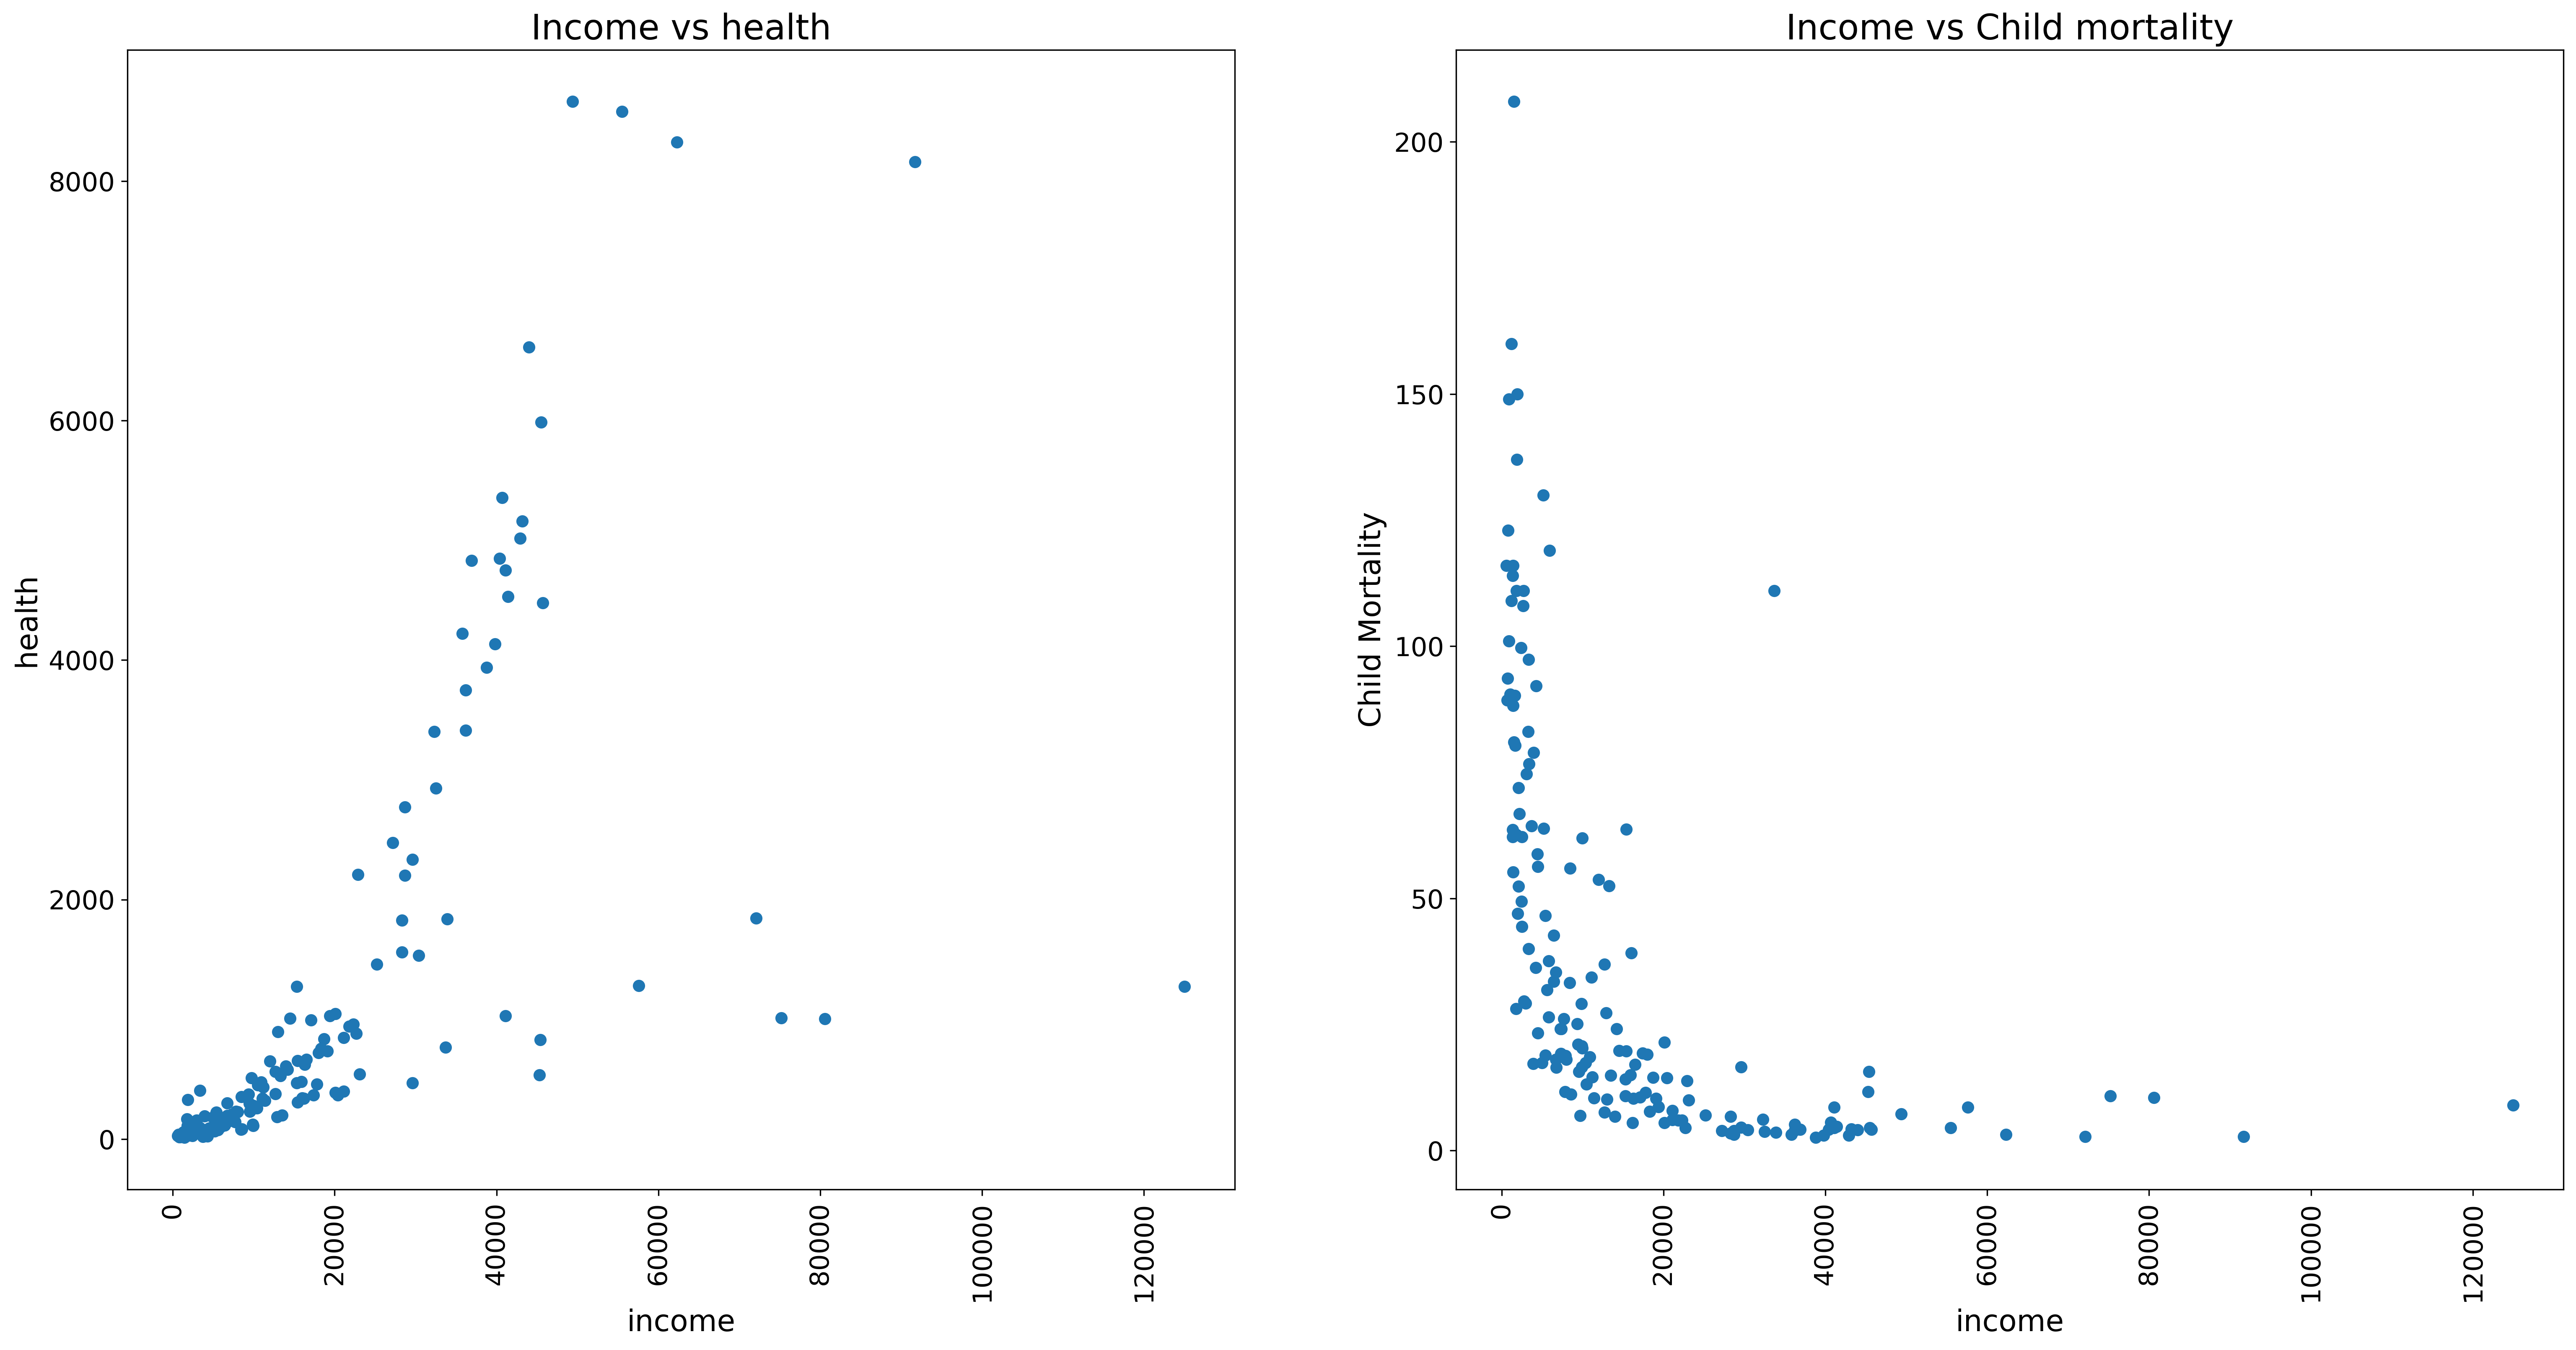

In [13]:
# Let's check for any patterns between income vs child mortality and health
plt.figure(figsize=[25,12],dpi=300)
plt.subplot(1,2,1)
plt.title("Income vs health",fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("income",fontsize=17)
plt.ylabel("health",fontsize=17)
plt.scatter(countries.income,countries.health)

plt.subplot(1,2,2)
plt.title("Income vs Child mortality",fontsize=20)
plt.xlabel("income",fontsize=17)
plt.ylabel("Child Mortality",fontsize=17)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.scatter(countries.income,countries.child_mort)
plt.show()

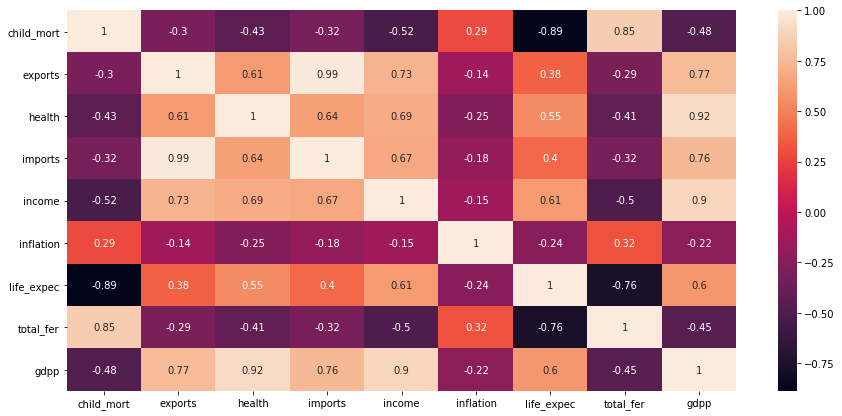

In [14]:
## we will try to see the Correlation amongst all variables
plt.figure(figsize = (15,7))
sns.heatmap(countries.corr(),annot = True)
plt.show()

#### Observations:
- Child mortality and life expectancy are strongly negative corelated. This shows a strong relation as if the child moratlity increases then the life expectancy would reduce.
- Child mortality and total fertility is also highly corelated with a coefficient of 0.85
- Import-export , health-gdpp , gdpp-imports, gdpp-exports are other set of highly corelated variables
- income is highly corelated to health 

In [15]:
countries.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

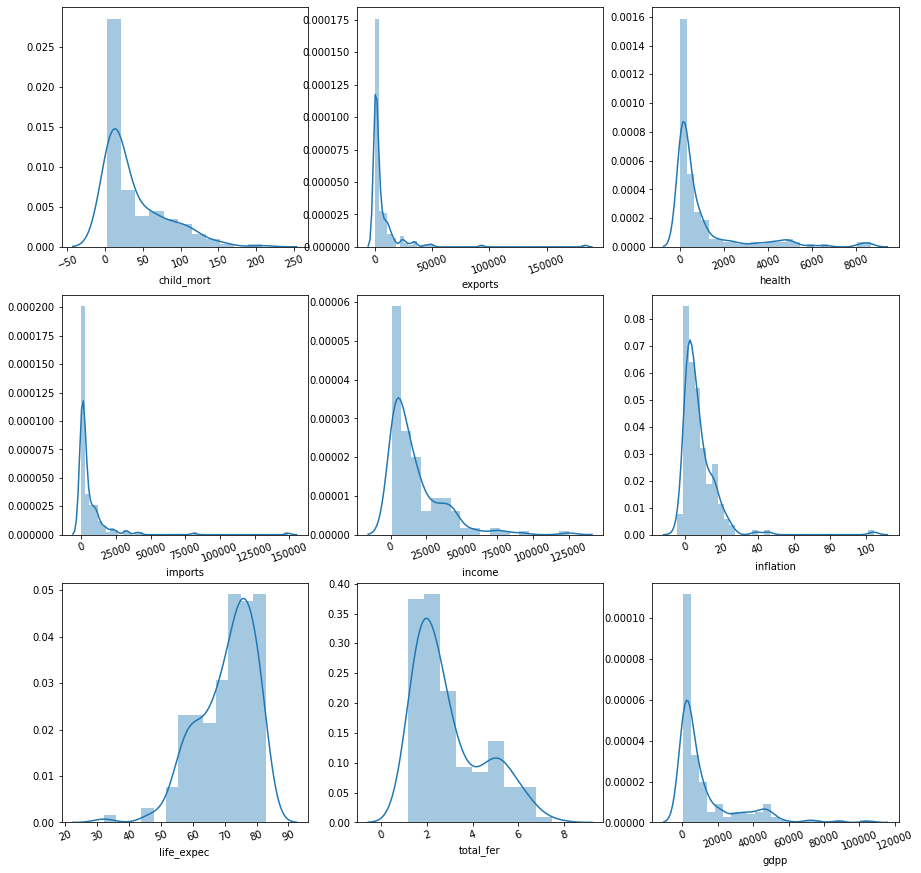

In [16]:
# Distribution Plot
plt.figure(figsize=(15, 15))
features = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(countries[i[1]])
    plt.xticks(rotation=20)

#### The above distribution plot shows us how the various columns in the dataset and the probabilty distribution function looks like, life_expectancy seems to be right skewed whereas all other columns are left skewed

### Plotting graphs to see the relatioship between countries and columns - income,health,child_mort,life_expec to see if we can spot some patterns

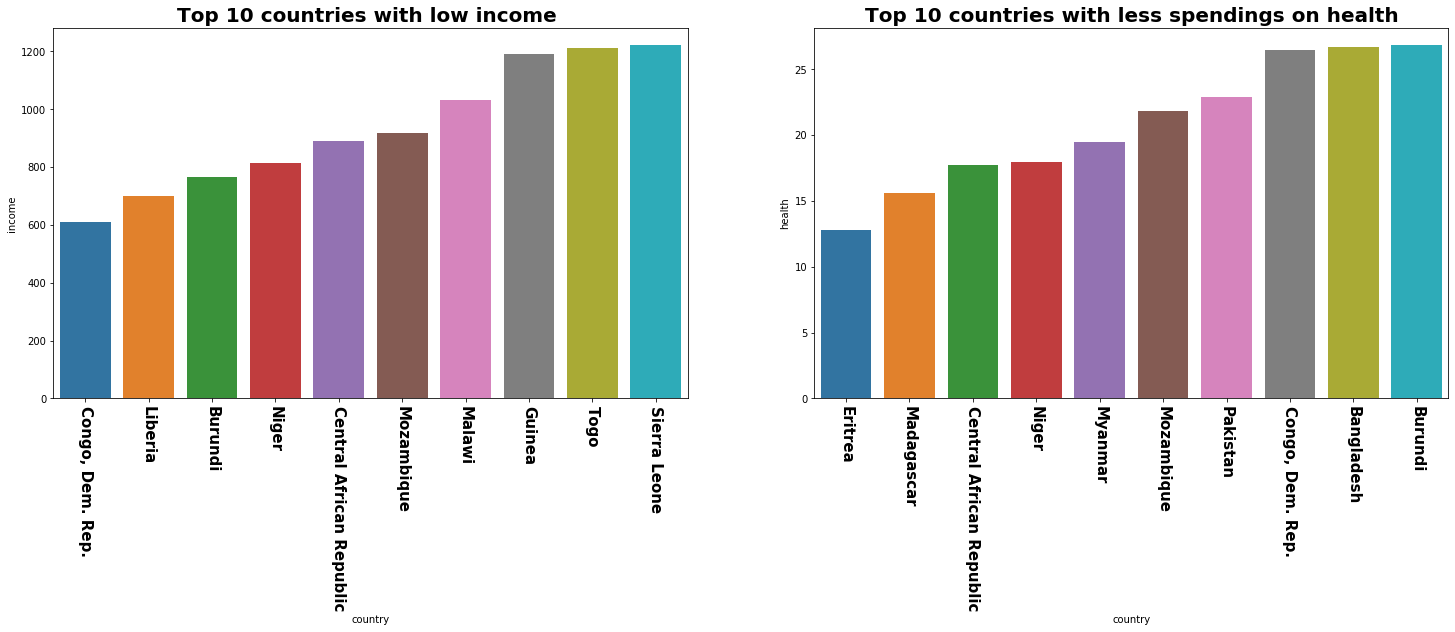

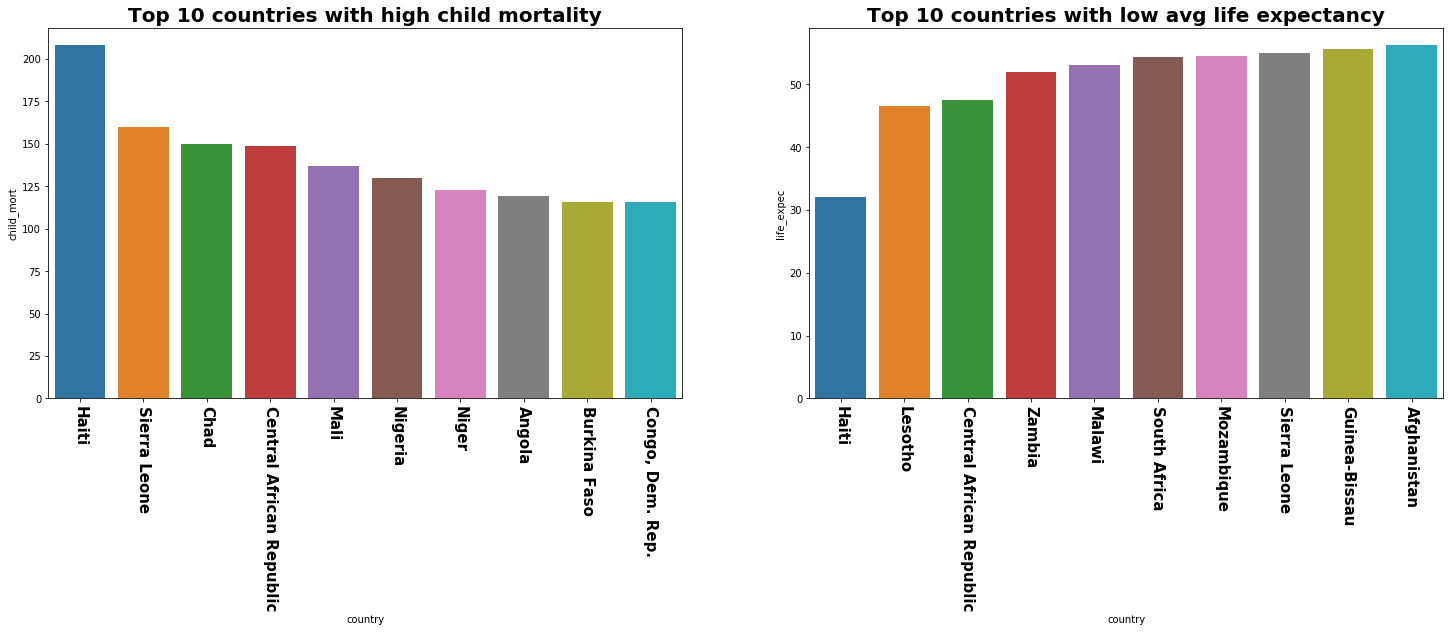

In [17]:
plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
income_df = countries[['country','income']].sort_values('income', ascending = True).head(10)
sns.barplot(x='country', y='income',data=income_df) 
plt.title('Top 10 countries with low income ',fontweight="bold", size=20)
plt.xticks(rotation=270, fontweight="bold",size=15)


plt.subplot(2,2,2)
health_df = countries[['country','health']].sort_values('health', ascending = True).head(10)
sns.barplot(x='country', y='health',data=health_df) 
plt.title('Top 10 countries with less spendings on health',fontweight="bold", size=20)
plt.xticks(rotation=270, fontweight="bold",size=15)
plt.show()

plt.figure(figsize=(25,15))
plt.subplot(2,2,3)
child_mor = countries[['country','child_mort']].sort_values('child_mort', ascending = False).head(10)
sns.barplot(x='country', y='child_mort',data=child_mor) 
plt.title('Top 10 countries with high child mortality',fontweight="bold", size=20)
plt.xticks(rotation=270, fontweight="bold",size=15)


plt.subplot(2,2,4)
life_expec_df = countries[['country','life_expec']].sort_values('life_expec', ascending = True).head(10)
sns.barplot(x='country', y='life_expec',data=life_expec_df) 
plt.title('Top 10 countries with low avg life expectancy',fontweight="bold", size=20)
plt.xticks(rotation=270, fontweight="bold",size=15)
plt.show()

#### Observations
- Countries which have less income tend to spend less on helath and have a high child moratlity rate. This can be seen from the above graphs -countries like Congo,Dem.Rep,Niger, Central African Republic exhibit such patterns
- Countries with less income also have less average life expectancy too - for example Malawi , Sierra Leone , Mozambique etc

- Overall we can say that income of a country  is one major contributing factor which influences child mortality rates , less average life expectancy and spending trends on health


## Outlier Analysis

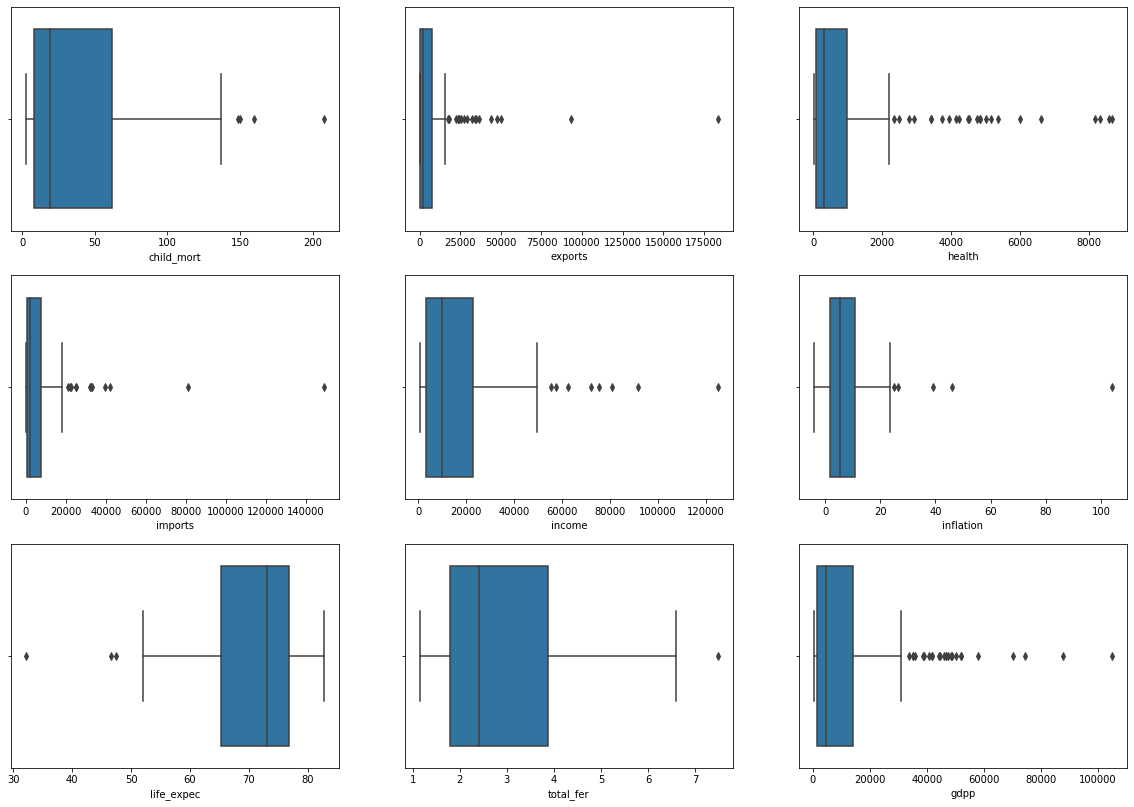

In [18]:
# checking outliers
plt.figure(figsize = (20,14))
features = countries.columns[1:]
for i in enumerate(features):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(countries[i[1]])

- The columns -exports, health,imports,income,total_fertility,gdpp have outliers in the upper range, we will cap these columns at 99%
- columns child_mortality and inflation also have outliers in the upper range but we will not cap these as these columns are important for analysis and the outlier points have a meaning and will be a major factor for clustering and analysis
- We can see outliers in the lower end for column life_expec too , but we will retain those values as low value indicates that few countires have a low life expectancy and are not really outliers

In [19]:
#Capping
q1 = countries['exports'].quantile(0.99)
q2 = countries['health'].quantile(0.99)
q3 = countries['imports'].quantile(0.99)
q4 = countries['income'].quantile(0.99)
q5 = countries['total_fer'].quantile(0.99)
q6 = countries['gdpp'].quantile(0.99)

countries['exports'][countries['exports']>= q1] = q1
countries['health'][countries['health']>= q2] = q2
countries['imports'][countries['imports']>= q3] = q3
countries['income'][countries['income']>= q4] = q4
countries['total_fer'][countries['total_fer']>= q5] = q5
countries['gdpp'][countries['gdpp']>= q6] = q6


In [20]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610.0000,9.4400,56.2000,5.8200,553.0000
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930.0000,4.4900,76.3000,1.6500,4090.0000
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900.0000,16.1000,76.5000,2.8900,4460.0000
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900.0000,22.4000,60.1000,6.1600,3530.0000
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100.0000,1.4400,76.8000,2.1300,12200.0000


### Checking for Hopkins statistics

In [21]:

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [22]:
hopkins(countries.drop('country', axis = 1))

0.9575027937031161

we have a high hopkins statistic value tells us that data set has high a high tendency to form good clusters

### Scaling of Data

In [23]:
countries.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

### Scaling the continuous Variables using Standard Scaling  technique

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
countries_scaled = scaler.fit_transform(countries.drop('country', axis = 1))


In [25]:
#converting the scaled series to a dataframe
countries_scaled = pd.DataFrame(countries_scaled, columns = countries.columns[1:])

In [26]:
countries_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.2915,-0.5696,-0.5670,-0.5987,-0.8517,0.1573,-1.6191,1.9264,-0.7023
1,-0.5389,-0.4739,-0.4404,-0.4136,-0.3869,-0.3123,0.6479,-0.8651,-0.4987
2,-0.2728,-0.4240,-0.4863,-0.4761,-0.2211,0.7893,0.6704,-0.0350,-0.4774
3,2.0078,-0.3812,-0.5341,-0.4640,-0.6120,1.3871,-1.1792,2.1540,-0.5310
4,-0.6956,-0.0867,-0.1784,0.1397,0.1253,-0.6017,0.7043,-0.5437,-0.0320


### K Means Clustering

We first need to determine the value of K , so we will use 2 methods - Silhouette score and Elbow curve-ssd to decide on the value of k


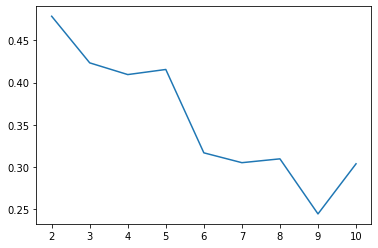

In [27]:
# silhouette analysis


from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(countries_scaled)
    ss.append([k, silhouette_score(countries_scaled, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

plt.show()



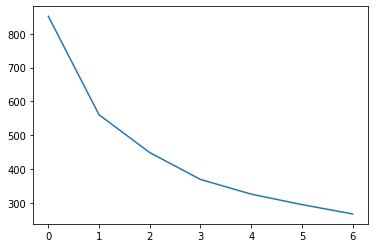

In [28]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(countries_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)
plt.show()

### Building the K means model with k=3

In [29]:
# model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state = 50)
kmeans.fit(countries_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [30]:
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [31]:
# assign the label
countries_kmean = countries.copy()  # creating a new df , countries_kmean so original countires df remains untouched
countries_kmean['cluster_id'] = kmeans.labels_
countries_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610.0000,9.4400,56.2000,5.8200,553.0000,2
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930.0000,4.4900,76.3000,1.6500,4090.0000,0
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900.0000,16.1000,76.5000,2.8900,4460.0000,0
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900.0000,22.4000,60.1000,6.1600,3530.0000,2
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100.0000,1.4400,76.8000,2.1300,12200.0000,0


In [32]:
countries_kmean.cluster_id.value_counts()

0    92
2    48
1    27
Name: cluster_id, dtype: int64

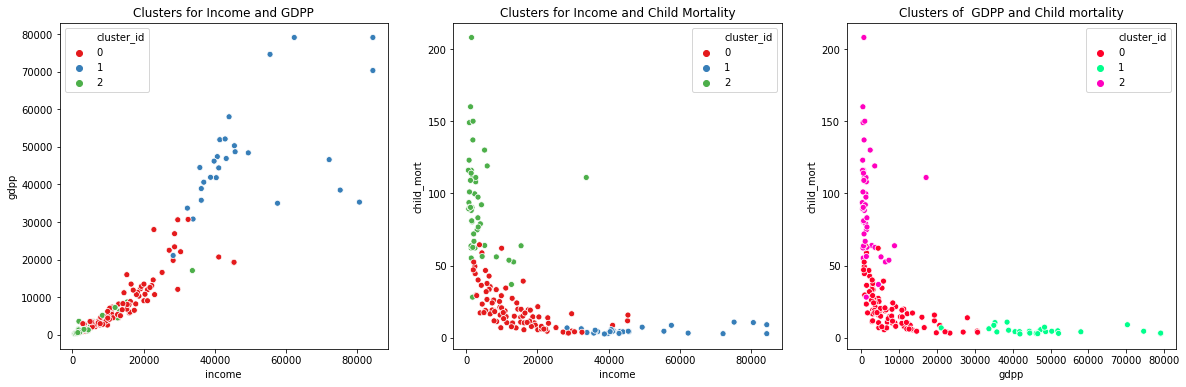

In [33]:
#visualizing the clusters
plt.subplots(1,3, figsize=(20,6))
plt.subplot(1,3,1)
sns.scatterplot(x='income', y='gdpp', hue='cluster_id',data=countries_kmean, palette='Set1')
plt.title('Clusters for Income and GDPP')
plt.subplot(1,3,2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id',data=countries_kmean, palette='Set1')
plt.title('Clusters for Income and Child Mortality')
plt.subplot(1,3,3)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id',data=countries_kmean,palette='gist_rainbow')
plt.title('Clusters of  GDPP and Child mortality')
plt.show()

- above scatterplot shows us cluster formations for columns gdpp, income and child mortality


### Cluster Profiling:

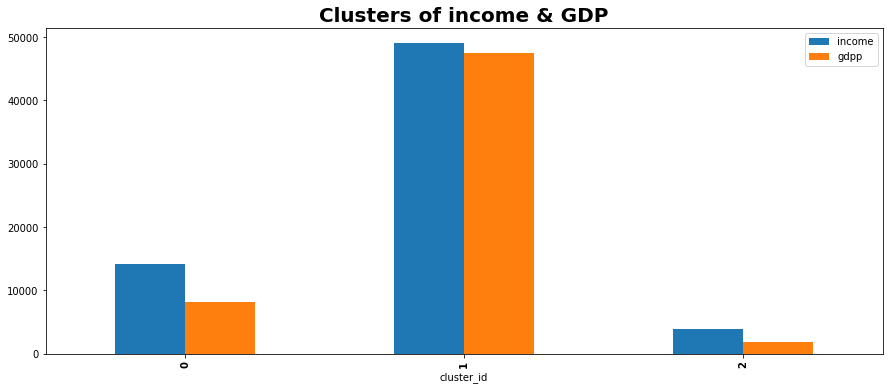

In [34]:
# Let us visualize clusters formed for income and gdpp
countries_kmean.drop(['country', 'exports', 'health', 'imports','child_mort','inflation', 'life_expec', 'total_fer'],axis = 1).groupby('cluster_id').mean().plot.bar(figsize=(15,6))
plt.title('Clusters of income & GDP',fontweight="bold", size=20)
plt.xticks(fontweight='bold')
plt.show()

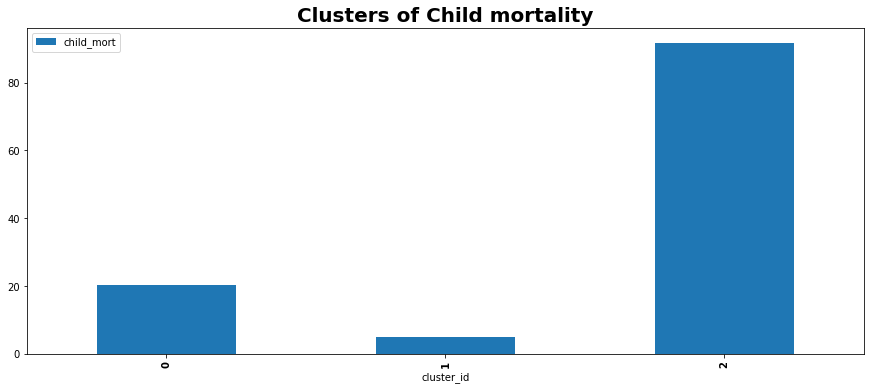

In [35]:
# Let us visualize clusters formed for mortality
countries_kmean.drop(['country', 'exports', 'health', 'imports','income', 'gdpp','inflation', 'life_expec', 'total_fer'],axis = 1).groupby('cluster_id').mean().plot.bar(figsize=(15,6))
plt.title('Clusters of Child mortality', fontweight="bold", size=20)
plt.xticks(fontweight='bold')
plt.show()

##### Observations from cluster profiling:
- Highest Income and GDPP are for countries belonging to cluster 2
- Highest Mortality rate is for countrires belonging to cluster 1

- Cluster 0 - moderat mortality rate , moderate gdpp   ,moderate income
- Cluster 1 - low mortality rate     , high  gdpp      ,high  income
- Cluster 2 - high mortality rate    , low gdpp        ,low income

From the clusters formed above we can categorise countries into:
- Underdeveloped (Cluster with low gdpp and low income having high mortality rate)
- Developing (Cluster with moderate gdpp and moderate income and moderate mortality rate)
- Developed (Cluster with high gdpp and high income and low mortality rate)

##### Based on above observations we can conclude that countires belongong to cluster 2 are in dire need of the financial  aids

In [36]:
# Filtering countries belonging to cluster 2 and sorting them based on 'high child_moratlity , low income and low gdpp
countries_need_aid= countries_kmean[countries_kmean['cluster_id']== 2].sort_values(by = ['child_mort','income','gdpp'],ascending=[False, True, True]).head(10)



In [37]:
print( 'Top 10 countries in dire need of aid  based on high moratality rate , low gdpp and low Income are:' , countries_need_aid['country'].values )

Top 10 countries in dire need of aid  based on high moratality rate , low gdpp and low Income are: ['Haiti' 'Sierra Leone' 'Chad' 'Central African Republic' 'Mali' 'Nigeria'
 'Niger' 'Angola' 'Congo, Dem. Rep.' 'Burkina Faso']


### Heirarachical Clustering

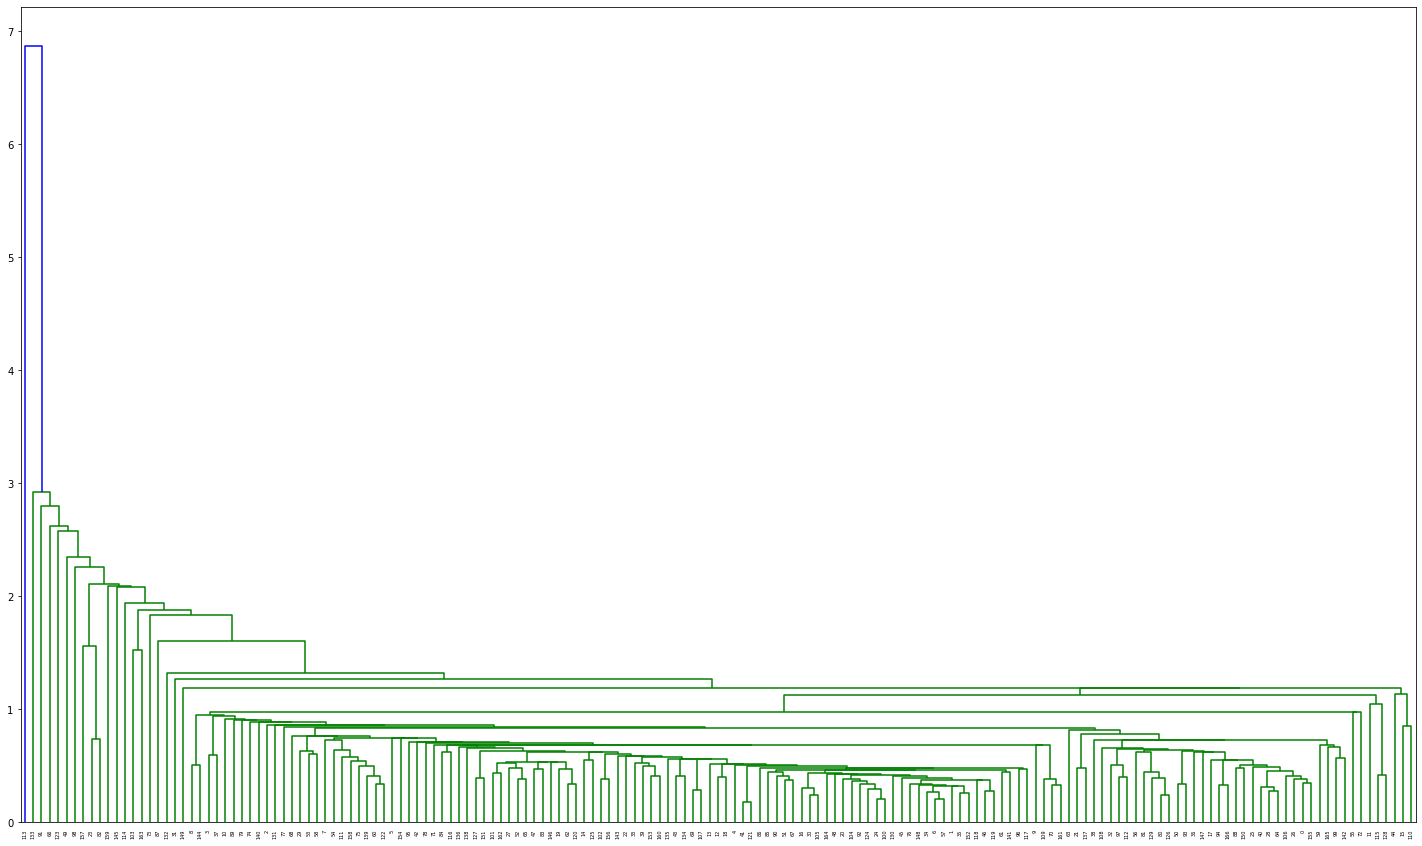

In [38]:
# single linkage
plt.figure(figsize = (25,15))
mergings = linkage(countries_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

- the above dendrogram obtained after single linkeage method does not give a clear picture on cluster formations 

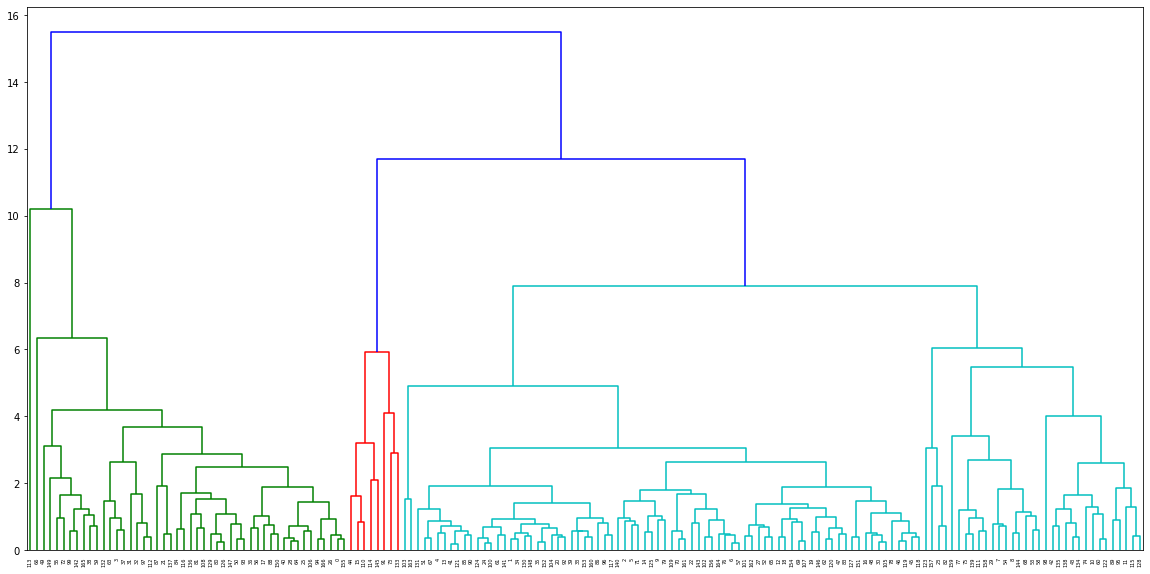

In [39]:
# complete linkage
plt.figure(figsize = (20,10))
mergings = linkage(countries_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

##### from  the above dendrogram we see that if cut the tree  at around 11 , then  we would get 3 disticnt clusters for our data, which is a good value for number of clsters as 4/5 would be high and 2 would not suit 

In [40]:
# cutting the tree 
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [41]:
# assign cluster labels

countries['cluster_labels'] = cluster_labels


In [42]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610.0000,9.4400,56.2000,5.8200,553.0000,0
1,Albania,16.6000,1145.2000,267.8950,1987.7400,9930.0000,4.4900,76.3000,1.6500,4090.0000,1
2,Algeria,27.3000,1712.6400,185.9820,1400.4400,12900.0000,16.1000,76.5000,2.8900,4460.0000,1
3,Angola,119.0000,2199.1900,100.6050,1514.3700,5900.0000,22.4000,60.1000,6.1600,3530.0000,0
4,Antigua and Barbuda,10.3000,5551.0000,735.6600,7185.8000,19100.0000,1.4400,76.8000,2.1300,12200.0000,1


In [43]:
countries.cluster_labels.value_counts()

1    111
0     48
2      8
Name: cluster_labels, dtype: int64

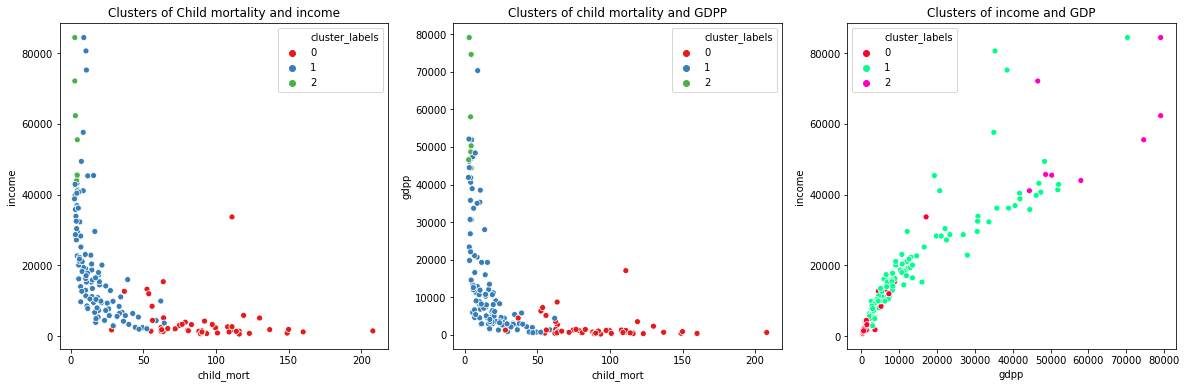

In [44]:
#visualizing the clusters
plt.subplots(1,3, figsize=(20,6))
plt.subplot(1,3,1)
sns.scatterplot(x='child_mort', y='income', hue='cluster_labels',data=countries, palette='Set1')
plt.title('Clusters of Child mortality and income')
plt.subplot(1,3,2)
sns.scatterplot(x='child_mort', y='gdpp', hue='cluster_labels',data=countries, palette='Set1')
plt.title('Clusters of child mortality and GDPP')
plt.subplot(1,3,3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_labels',data=countries,palette='gist_rainbow')
plt.title('Clusters of income and GDP')
plt.show()

- above scatterplot shows us cluster formations for columns gdpp, income and child mortality


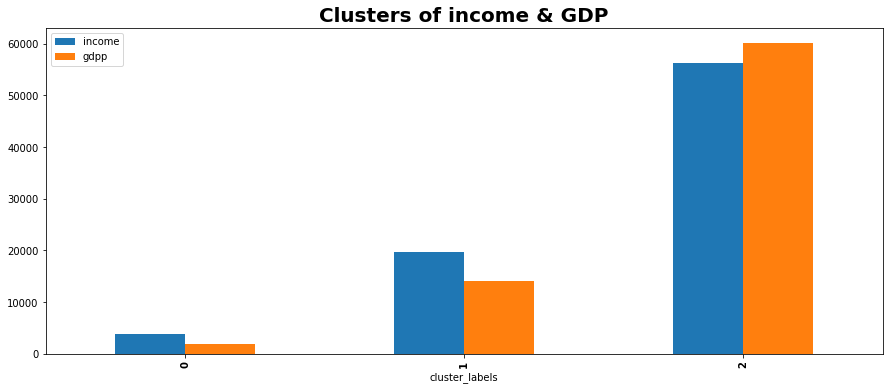

In [45]:
#cluster profiling of heirarchical clusters
countries.drop(['country', 'exports', 'health', 'imports','child_mort','inflation', 'life_expec', 'total_fer'],axis = 1).groupby('cluster_labels').mean().plot.bar(figsize=(15,6))
plt.title('Clusters of income & GDP',fontweight="bold", size=20)
plt.xticks(fontweight='bold')
plt.show()

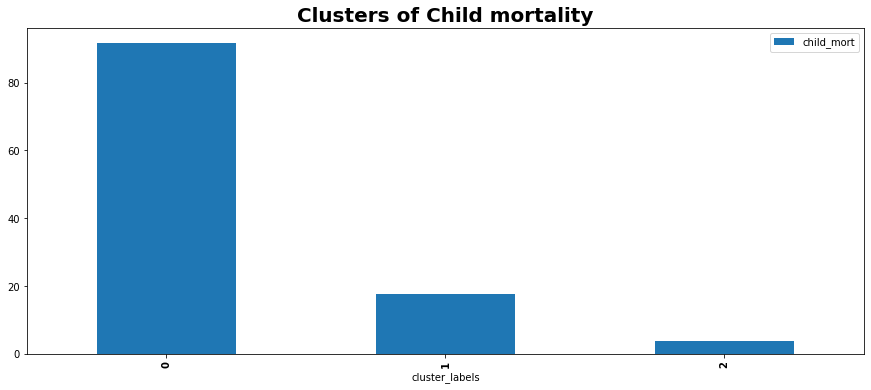

In [46]:
countries.drop(['country', 'exports', 'health', 'imports','income', 'gdpp','inflation', 'life_expec', 'total_fer'],axis = 1).groupby('cluster_labels').mean().plot.bar(figsize=(15,6))
plt.title('Clusters of Child mortality', fontweight="bold", size=20)
plt.xticks(fontweight='bold')
plt.show()

##### Observations from cluster profiling:
- Highest Income and GDPP are for countries belonging to cluster 2
- Highest Mortality rate is for countrires belonging to cluster 0

- Cluster 0 - high mortality rate            , low gdpp       ,low income
- Cluster 1 - moderate child mortality rate  , moderate gdpp  ,moderate income
- Cluster 2 - low mortality rate             , high gdpp      ,high income

From the clusters formed above we can categorise countries into:
- Underdeveloped (Cluster with low gdpp and low income having high mortality rate)
- Developing (Cluster with moderate gdpp and moderate income and moderate mortality rate)
- Developed (Cluster with high gdpp and high income and low mortality rate)

##### Based on above observations we can conclude that countires belonging to cluster 0 are in dire need of the financial  aids

In [47]:
# Filtering countries belonging to cluster 0 and sorting them based on 'high child_moratlity , low income and low gdpp
countries_need_aid1= countries[countries['cluster_labels']== 0].sort_values(by = ['child_mort','income','gdpp'],ascending=[False, True, True]).head(10)



In [48]:
print( 'Top 10 countries in dire need of aid  based on high mortality rate , low gdpp and low Income are:' , countries_need_aid1['country'].values )

Top 10 countries in dire need of aid  based on high mortality rate , low gdpp and low Income are: ['Haiti' 'Sierra Leone' 'Chad' 'Central African Republic' 'Mali' 'Nigeria'
 'Niger' 'Angola' 'Congo, Dem. Rep.' 'Burkina Faso']


### Conclusion

##### We use K-means and Heirarchical clustering methods to analyze the countires dataset and get the list of countries to report to the CEO which should be given financial aid.

#### Inferences from K mean:
- Using the elbow method and sillhouette score , we determind the value of clsuters to be taken as 3 and cluster the data.
- After forming the clsuters , we checked the clusters based on columns child morta;ity , gdpp and income of a country.
- From the cluster patterns we could see that there are 3 categories in which the countires can be classified: 
- Underdeveloped (Cluster with low gdpp and low income having high mortality rate)
- Developing (Cluster with moderate gdpp and moderate income and moderate mortality rate)
- Developed (Cluster with high gdpp and high income and low mortality rate)
- out of 167 countries - 48 countries were clustered as Underdeveloped which has a very low income and gdpp and high rate of child mortality
- Top 10 countries found from this list are -'Haiti' 'Sierra Leone' 'Chad' 'Central African Republic' 'Mali' 'Nigeria''Niger' 'Angola' 'Congo, Dem. Rep.' 'Burkina Faso' . 


#### Inferences from Heirarchical Clustering:
- In heirarchical clustering , we used single linkeage methid which did not yield a good dendrogram hence we went for complete linkegae
- In complete linkeage , we proceeded with n=3 and formed the clusters. 
- From the cluster patterns we could see that there are 3 categories in which the countires can be classified: 
- Underdeveloped (Cluster with low gdpp and low income having high mortality rate)
- Developing (Cluster with moderate gdpp and moderate income and moderate mortality rate)
- Developed (Cluster with high gdpp and high income and low mortality rate)
- out of 167 countries - 48 countries were clustered as Underdeveloped which has a very low income and gdpp and high rate of child mortality

- Top 10 countries found from this list are -'Haiti' 'Sierra Leone' 'Chad' 'Central African Republic' 'Mali' 'Nigeria' 'Niger' 'Angola' 'Congo, Dem. Rep.' 'Burkina Faso'

Please note the order in which these countries have been reported from the underdeveloped cluster are based on child moratlity, gdpp and income columns. The cluster has been sorted in the order of high mortality , low income and low gdpp and then the countires from both the clustering techniques have been reported. We can change this order as per need basis and get a different list based on our requierment.

### We observe that both the clustering techinques have given us the same list of top 10 countires which are in dire need of funds and these can be reported to the CEO for further action